# Import all neccessary libraries

In [237]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.utils import save_image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from google.colab import files
from IPython.display import clear_output
from torch.optim import Adam
import torch.nn.functional as F
from torchvision import transforms
from torch.nn import Module, Sequential, ReflectionPad2d, Conv2d

In [238]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [239]:
%%bash

#gdown "1EpkBA2K2eYILDSyPTt0fztz59UjAIpZU"
#gdown "1bMfhMMwPeXnYSQI6cDWElSZxOxc6aVyr"

In [240]:
 # Undo the above preprocessing.
def deNorm(output_tensor):
    Normalize = transforms.Compose([transforms.Normalize(mean=[-123.68, -116.779, -103.939], std=[1,1,1])])
    output_tensor = Normalize(output_tensor.squeeze(0).cpu()) / 255
    output_tensor.clamp_(0, 1)
    return output_tensor

In [241]:
def preprocess(image_name, image_size):
    image = Image.open(image_name).convert('RGB')
    if type(image_size) is not tuple:
        image_size = tuple([int((float(image_size) / max(image.size))*x) for x in (image.height, image.width)])
    Loader = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
    # rgb2bgr = transforms.Compose([transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])])])
    Normalize = transforms.Compose([transforms.Normalize(mean=[123.68, 116.779, 103.939], std=[1,1,1])])
    # tensor = Normalize(rgb2bgr(Loader(image) * 255)).unsqueeze(0)
    tensor = Normalize(Loader(image) * 255).unsqueeze(0)
    return tensor

In [242]:
image_size = (512, 512)

content_image = preprocess('stata.png', image_size).to(device)
style_image = preprocess('style2.png', image_size).to(device)
gen_image = content_image.clone().requires_grad_(True)

In [243]:
def plot_image(images, names=None, denorm=False):

  if type(images) is list:
    plt.figure(figsize=(5 * len(images), 8))

    for i in range(len(images)):
      if denorm:
        image = deNorm(images[i])
      else:
        image = images[i]

      plt.subplot(1, len(images), i + 1)

      if names == None:
        plt.title('Image {}'.format(i))
      else:
        plt.title(names[i])

      plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu())
      plt.axis('off')

    plt.show()
  else:
    if denorm:
      image = deNorm(images[i])
    else:
      image = images

    plt.figure(figsize=(4, 8))

    plt.subplot(1, 1, 1)
    plt.title('Content Image')
    plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu())
    plt.axis('off')

    plt.show()

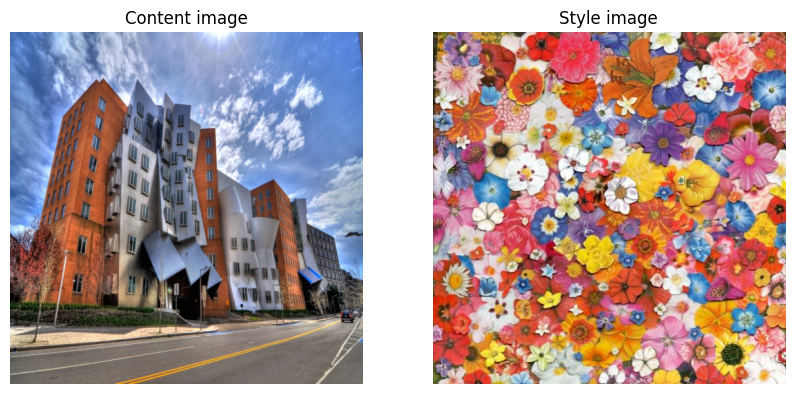

In [244]:
plot_image([content_image, style_image], names=['Content image', 'Style image'], denorm=True)

In [245]:
def calculate_mean_std(features, eps=1e-5):
    size = features.size()
    N, C = size[:2]
    features_var = features.view(N, C, -1).var(dim=2) + eps
    features_std = features_var.sqrt().view(N, C, 1, 1)
    features_mean = features.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return features_mean, features_std

In [246]:
class ConvBlock(Module):
    def __init__(self, in_channels, out_channels, kernel_size, activation=True, max_pool=False, upsample=False):
        super().__init__()

        self.activation = activation
        self.max_pool = max_pool
        self.upsample = upsample
        self.conv = Sequential(ReflectionPad2d(kernel_size // 2),
                               Conv2d(in_channels, out_channels, kernel_size))

    def forward(self, x):
        conv = self.conv(x)
        if self.activation:
            conv = F.relu(conv)
        if self.max_pool:
            conv = F.max_pool2d(conv, kernel_size=2, stride=2, ceil_mode=True)
        elif self.upsample:
            conv = F.interpolate(conv, scale_factor=2)
        return conv


class Network(Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.encoder = Sequential(Sequential(Conv2d(3, 3, kernel_size=1),
                                             ConvBlock(3, 64, kernel_size=3)),
                                  Sequential(ConvBlock(64, 64, kernel_size=3, max_pool=True),
                                             ConvBlock(64, 128, kernel_size=3)),
                                  Sequential(ConvBlock(128, 128, kernel_size=3, max_pool=True),
                                             ConvBlock(128, 256, kernel_size=3)),
                                  Sequential(ConvBlock(256, 256, kernel_size=3),
                                             ConvBlock(256, 256, kernel_size=3),
                                             ConvBlock(256, 256, kernel_size=3, max_pool=True),
                                             ConvBlock(256, 512, kernel_size=3)))

        # Decoder
        self.decoder = Sequential(ConvBlock(512, 256, kernel_size=3, upsample=True),
                                  ConvBlock(256, 256, kernel_size=3),
                                  ConvBlock(256, 256, kernel_size=3),
                                  ConvBlock(256, 256, kernel_size=3),
                                  ConvBlock(256, 128, kernel_size=3, upsample=True),
                                  ConvBlock(128, 128, kernel_size=3),
                                  ConvBlock(128, 64, kernel_size=3, upsample=True),
                                  ConvBlock(64, 64, kernel_size=3),
                                  ConvBlock(64, 3, kernel_size=3, activation=False))

        # Freeze Encoder Parameters
        for parameter in self.encoder.parameters():
            parameter.requires_grad = False

    # Get Features From All Encoder Layers
    def get_all_encoder_features(self, input):
        features = [input]
        for i in range(4):
            features.append(self.encoder[i](features[-1]))
        return features[1:]

    # Apply Adaptive Instance Normalization
    def adain(self, content_feats, style_feats):
        size = content_feats.size()
        style_mean, style_std = calculate_mean_std(style_feats)
        content_mean, content_std = calculate_mean_std(content_feats)
        normalized_feats = (content_feats - content_mean.expand(size)) / content_std.expand(size)
        return normalized_feats * style_std.expand(size) + style_mean.expand(size)

    # Calculate Content Loss
    def content_loss(self, input, target):
        return F.mse_loss(input, target)

    # Calculate Style Loss
    def style_loss(self, input, target):
        input_mean, input_std = calculate_mean_std(input)
        target_mean, target_std = calculate_mean_std(target)
        return F.mse_loss(input_mean, target_mean) + F.mse_loss(input_std, target_std)

    def forward(self, content, style, alpha=1):
        assert 0 <= alpha <= 1
        content_feats = self.encoder(content)
        style_feats = self.get_all_encoder_features(style)
        stylized_feats = self.adain(content_feats, style_feats[-1])
        stylized_feats = alpha * stylized_feats + (1 - alpha) * content_feats

        generated_stylization = self.decoder(stylized_feats)
        generated_stylization_feats = self.get_all_encoder_features(generated_stylization)

        content_loss = self.content_loss(generated_stylization_feats[-1], stylized_feats)
        style_loss = self.style_loss(generated_stylization_feats[0], style_feats[0])
        for i in range(1, 4):
            style_loss += self.style_loss(generated_stylization_feats[i], style_feats[i])
        return content_loss, style_loss

In [247]:
network = Network().to(device)

state = network.state_dict()

new_encoder_state_values = iter(torch.load('vgg_normalised.pth').values())
new_decoder_state_values = iter(torch.load('decoder.pth').values())

for i, key in enumerate(state):
    if key.startswith('encoder'):
        state[key] = next(new_encoder_state_values)
    elif key.startswith('decoder'):
        state[key] = next(new_decoder_state_values)

network.load_state_dict(state)

<All keys matched successfully>

In [248]:
def adjust_learning_rate(optimizer, lr, lr_decay, iteration_count):
    lr /= (1 + lr_decay * iteration_count)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def train(network, content, style, lr=1e-4, lr_decay=5e-5, content_weight=1, style_weight=10, iterations=30):
    optimizer = Adam(network.decoder.parameters(), lr=lr)
    for iter in tqdm(range(iterations)):
        optimizer.zero_grad()
        adjust_learning_rate(optimizer, lr, lr_decay, iteration_count=iter)
        content_loss, style_loss = network(content, style)
        total_loss = content_weight * content_loss + style_weight * style_loss
        total_loss.backward()
        optimizer.step()
    torch.save(network.state_dict(), 'network.pth')

# Run
train(network, content_image, style_image)

  0%|          | 0/30 [00:00<?, ?it/s]

In [249]:
def prep(image, size=1280, to_tensor=False, device=device):
    resize = transforms.Compose([transforms.Resize(size, Image.LANCZOS),
                                 transforms.CenterCrop(size)])
    image = resize(image.convert('RGB'))
    if to_tensor:
        return transforms.ToTensor()(image).unsqueeze(0).to(device)
    else:
        return image

# Post-processing
def post(tensor):
    return transforms.ToPILImage()(tensor.detach().cpu().squeeze(0).clamp_(0, 1))

def draw(input, content_image, style_image):
    output = post(input)

    clear_output(wait=True)
    plt.figure(figsize=(18, 6))

    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(prep(content_image))
    ax1.axis('off')
    ax1.set_title('Content Image')

    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(prep(style_image))
    ax2.axis('off')
    ax2.set_title('Style Image')

    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(output)
    ax3.axis('off')
    ax3.set_title('Output Image')

    plt.show()
    return output

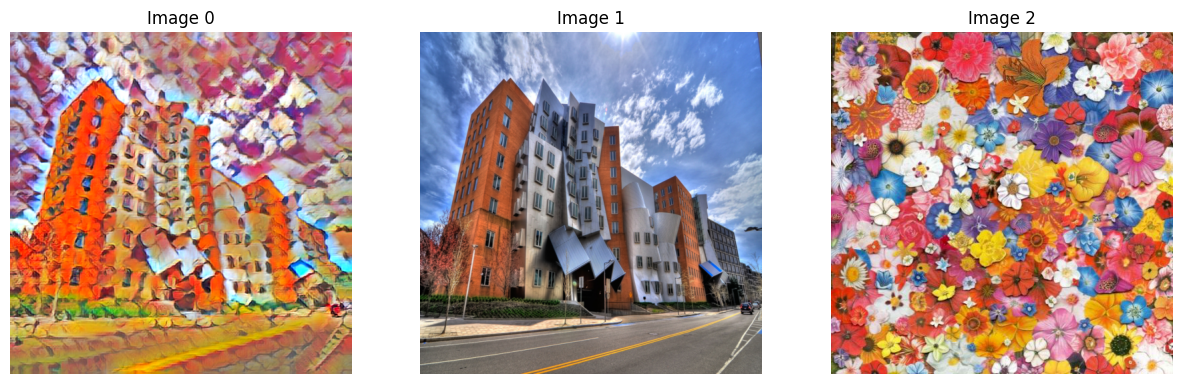

CPU times: user 795 ms, sys: 108 ms, total: 904 ms
Wall time: 794 ms


In [250]:
%%time

def transfer_style(network, content, style, alpha=1):
    assert 0 <= alpha <= 1
    content_feats = network.encoder(content)
    style_feats = network.encoder(style)

    network.eval()
    with torch.no_grad():
        stylized_feats = network.adain(content_feats, style_feats)
        stylized_feats = stylized_feats * alpha + content_feats * (1 - alpha)
        output = plot_image([network.decoder(stylized_feats), content_image, style_image], denorm=True)
    return output

# Run
network.load_state_dict(torch.load('network.pth'))
output = transfer_style(network, content_image, style_image, alpha=1)